# NSVM

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
print("Tensor Flow version {}".format(tf.__version__))

Tensor Flow version 0.11.0


## Load data

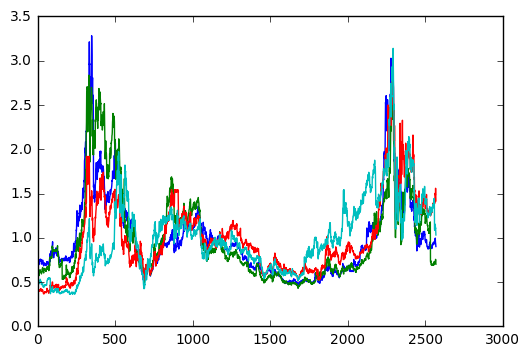

In [18]:
#To load data
datas = np.load("stock_revised.npz")
data = datas["data"]
TRAIN_LEN = 1500

#small scale#
'''TRAIN_LEN = 500
data = data[:, :600]
print data.shape'''
#small scale#


plt.figure()
plt.plot(data[0])
plt.plot(data[1])
plt.plot(data[2])
plt.plot(data[3])

In [3]:
CORR_DIM = 6
LEN = len(data[0])
xbat = data.shape[0]
xlen = data.shape[1]

Xs = np.zeros((xbat/CORR_DIM, xlen, CORR_DIM))

for i in range(xbat / CORR_DIM):
    Xs[i,:,:] = np.transpose(data[6*i:6*(i+1), :])
    
print Xs.shape
X_train = Xs[:,:TRAIN_LEN,:]
X_test = Xs[:,:,:]

BATCH_NUM = xbat / CORR_DIM

(27, 2571, 6)


In [4]:
EMBED_DIM = 1
'''EMBED_DIM = 20
LEN = len(data[0])
TRAIN_LEN = 1500
BATCH_NUM = len(data)


X_raw = np.zeros([BATCH_NUM, LEN, 1])
X_raw[:, :,0] = data
print 

xbat = X_raw.shape[0]
xlen = X_raw.shape[1]
xwid = X_raw.shape[2]
newlen = xlen - EMBED_DIM + 1
newwid = xwid * EMBED_DIM
Xs = np.zeros((xbat, newlen, newwid))
#print X_test_raw.shape
for i in range(EMBED_DIM):
    Xs[:, :, i*xwid:(i+1)*xwid] = X_raw[:, i:i+newlen, :]

#print Xs
X_train = Xs[:,:TRAIN_LEN,:]
X_test = Xs[:,:,:]'''
print X_train.shape
print X_test.shape

(27, 1500, 6)
(27, 2571, 6)


## Construct the graph

In [5]:
N_x = CORR_DIM
N_hi = [10,10]
N_z = 2
N_hg = [10,10]
N_o = N_x
CORR_RANK = 0

#2:
#NLL_train = -1.81017580088
#NLL_test = -1.60838533647
#1:
#NLL_train = -2.28424248576
#NLL_test = -2.20789705344
#0:
#NLL_train = -2.57541425927
#NLL_test = -2.3767351664
#NLL_train = -2.13588618534
#NLL_test = -2.11480672778
#NLL_train = -2.14512410261
#NLL_test = -2.10953426166


#T = TRAIN_LEN
M = BATCH_NUM
L = 10
LEARNING_RATE = 0.001

DROPOUT = 0

Dtype = tf.float32

In [12]:
tf.reset_default_graph()
xs = tf.placeholder(Dtype, [M, None, N_x])
rv = tf.placeholder(Dtype, [M, L, None, N_z])
outs = xs[:, :, N_x-N_o:N_x]

eps = 1e-5

def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.01)
    return tf.Variable(initial)

def biases(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

#Inference Net
with tf.variable_scope("InfNet"):
    cells = []
    for n_h in N_hi:
        GRUcell = tf.nn.rnn_cell.GRUCell(num_units = n_h)
        GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
        cells.append(GRUcell)
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)

    hi, states = tf.nn.dynamic_rnn(
        cell,
        inputs = xs,
        sequence_length = None,
        dtype = Dtype
    )

    hi_flat = tf.reshape(hi, [-1, N_hi[-1]])  #N_hi[-1]

    W_fc_i = weights([N_hi[-1], 2*N_z])
    b_fc_i = weights([2*N_z])
    outi_flat = tf.matmul(hi_flat, W_fc_i) + b_fc_i
    outi = tf.reshape(outi_flat, [M, -1, 2*N_z])

    mu_z, log_nu_z = tf.split(2, 2, outi) #[M, T, N_z]
    nu_z = tf.exp(log_nu_z) + eps #use exp to be sure that variance are greater than zero.


zs = tf.expand_dims(mu_z, 1)+ rv * tf.expand_dims(tf.sqrt(nu_z), 1)  #zs : [M, L, T, N_z]
x_extd = tf.pack([xs]*L, 1)

x_and_z_flat = tf.reshape(tf.concat(3, [zs, x_extd]), [M, -1, N_x+N_z] )   #the input of generation net

with tf.variable_scope("GenNet"):
    cells = []
    for n_h in N_hg:
        GRUcell = tf.nn.rnn_cell.GRUCell(num_units = n_h)
        GRUcell = tf.nn.rnn_cell.DropoutWrapper(GRUcell, output_keep_prob = 1 - DROPOUT)
        cells.append(GRUcell)
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)


    hg, final_state = tf.nn.dynamic_rnn(
        cell,
        inputs = x_and_z_flat,
        sequence_length = None,
        #initial_state = init_val
        dtype = Dtype
    )
    #hg : [M*L, T, N_hg]

    hg_flat = tf.reshape(hg, [-1, N_hg[-1]])

    W_fc_g = weights([N_hg[-1], 2*N_o])
    b_fc_g = biases([2*N_o])
    outg_flat = tf.matmul(hg_flat, W_fc_g) + b_fc_g
    outg = tf.reshape(outg_flat, [M, L, -1, 2*N_o])

    '''W_fc_g_corr = weights([N_hg[-1], CORR_RANK*N_o])*10
    b_fc_g_corr = biases([CORR_RANK*N_o])
    corr_nu_x_flat = tf.matmul(hg_flat, W_fc_g_corr) + b_fc_g_corr
    corr_nu_x = tf.reshape(corr_nu_x_flat, [M, L, -1, CORR_RANK, N_o])'''  #This part is used for covariance matrix. For pre-training, it is not used.

    mu_x, log_diag_nu_x = tf.split(3, 2, outg) #[M, L, T, N_x]
    
    nu_x = tf.matrix_diag(tf.exp(log_diag_nu_x))# * (tf.matrix_diag(tf.ones_like(log_diag_nu_x, dtype = Dtype)) + tf.tanh(tf.batch_matmul(tf.transpose(corr_nu_x, [0,1,2,4,3]), corr_nu_x)))
    

KL = 0.5 * (tf.reduce_mean(mu_z**2) + tf.reduce_mean(nu_z) - tf.reduce_mean(tf.log(nu_z)))

x_err = tf.expand_dims(tf.expand_dims(outs[:,1:, :], dim = 1) - mu_x[:,:,:-1, :], dim = 3)

EXP = -0.5 * (tf.reduce_mean(tf.log(tf.matrix_determinant(nu_x[:,:,:-1, :, :]))) + \
        tf.reduce_mean(tf.batch_matmul(tf.batch_matmul(x_err, tf.matrix_inverse(nu_x[:,:,:-1,:,:])), tf.transpose(x_err, [0,1,2,4,3]))))




loss = -(EXP - KL)# + 0.2 * (tf.reduce_mean(W_fc_i**2)+tf.reduce_mean(W_fc_g**2))
optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
fetch_loss = [loss]


mu_x_pred = tf.reduce_mean(mu_x, 1)
nu_x_pred = tf.reduce_mean(nu_x, 1)
zs_pred = tf.reduce_mean(zs, 1)

In [13]:
print len(tf.trainable_variables())   #This is used to set the result of pretraining.
for i in tf.trainable_variables():
    print i.name

20
InfNet/RNN/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Matrix:0
InfNet/RNN/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Bias:0
InfNet/RNN/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Matrix:0
InfNet/RNN/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Bias:0
InfNet/RNN/MultiRNNCell/Cell1/GRUCell/Gates/Linear/Matrix:0
InfNet/RNN/MultiRNNCell/Cell1/GRUCell/Gates/Linear/Bias:0
InfNet/RNN/MultiRNNCell/Cell1/GRUCell/Candidate/Linear/Matrix:0
InfNet/RNN/MultiRNNCell/Cell1/GRUCell/Candidate/Linear/Bias:0
InfNet/Variable:0
InfNet/Variable_1:0
GenNet/RNN/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Matrix:0
GenNet/RNN/MultiRNNCell/Cell0/GRUCell/Gates/Linear/Bias:0
GenNet/RNN/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Matrix:0
GenNet/RNN/MultiRNNCell/Cell0/GRUCell/Candidate/Linear/Bias:0
GenNet/RNN/MultiRNNCell/Cell1/GRUCell/Gates/Linear/Matrix:0
GenNet/RNN/MultiRNNCell/Cell1/GRUCell/Gates/Linear/Bias:0
GenNet/RNN/MultiRNNCell/Cell1/GRUCell/Candidate/Linear/Matrix:0
GenNet/RNN/MultiRNNCell/Cell1/GRUCell/Candida

## Train the model and see the result

In [14]:
# hparams pt. 3
NUM_EPOCHS = 3000
PRINT_LOSS_FREQ = 5
TEST_FREQ = 25
SAVE_FREQ = 50
SAVE_PATH = 'NSVM-stock-checkpoint'

random_v = np.random.randn(M,L,TRAIN_LEN-EMBED_DIM+1,N_z)

test_data = X_test[:,EMBED_DIM:]
random_v_test = np.random.randn(M, L, LEN-EMBED_DIM+1, N_z)

In [53]:
RESTORE_FLAG = False # if TRUE, pretrained model will be restored and trained
loss_history = []
loss_test_history = []
nll_train_history = []
nll_test_history = []

saver = tf.train.Saver()
with tf.Session() as sess:
    print('=======================================================================================================')
    sess_start = datetime.now()
    print('training session starts @ {}'.format(sess_start))
    print('-------------------------------------------------------------------------------------------------------')
    
    if RESTORE_FLAG is not True:
        init = tf.initialize_all_variables()
        sess.run(init)

        loader = tf.train.Saver(var_list=tf.trainable_variables()[:20])   #This is used to load pre-training result.
        loader.restore(sess, "nsvm-pretrain")
    else:
        checkpoint_path = tf.train.latest_checkpoint('')
        saver.restore(sess, checkpoint_path)
        print('-------------------------------------------------------------------------------------------------------')
        print('{}, model loaded from file: {}'
              .format(datetime.now(), checkpoint_path))
        print('-------------------------------------------------------------------------------------------------------')
        
        
    for epoch in range(NUM_EPOCHS+1):
        if (epoch % PRINT_LOSS_FREQ == 0):
            loss = 0
            for i in range(BATCH_NUM / M):
                feed_data = X_train[i*M:(i+1)*M]
                loss_cur = sess.run(fetches = fetch_loss, feed_dict = {xs:feed_data, rv:random_v})
                loss = (loss * i + loss_cur[0]) / (i+1)
            loss_history.append(loss)
            print('{}, epoch {}: loss = {}'.format(datetime.now(), epoch, loss))
            
            
        if (epoch % TEST_FREQ == 0):
            mu_pred = np.zeros((BATCH_NUM, LEN-EMBED_DIM, CORR_DIM))
            nu_pred = np.zeros((BATCH_NUM, LEN-EMBED_DIM, CORR_DIM, CORR_DIM))
            loss_tot = 0
            for i in range(BATCH_NUM / M):
                feed_data = X_test[i*M:(i+1)*M]
                loss_cur, mu_pred_i, nu_pred_i = sess.run(fetches = [fetch_loss, mu_x_pred, nu_x_pred], feed_dict = {xs:feed_data, rv:random_v_test})
                mu_pred[i*M:(i+1)*M, :] = mu_pred_i[:, :LEN-EMBED_DIM, :]
                nu_pred[i*M:(i+1)*M, :] = nu_pred_i[:, :LEN-EMBED_DIM, :]
                loss_tot = (loss_tot * i + loss_cur[0]) / (i+1)
                
            loss_test = (loss_tot * (LEN-EMBED_DIM) - loss * (TRAIN_LEN-EMBED_DIM) ) / (LEN-TRAIN_LEN)
            loss_test_history.append(loss_test)

            nlls = np.zeros((BATCH_NUM, LEN-EMBED_DIM))
            for m in range(BATCH_NUM):
                for t in range(LEN-EMBED_DIM):
                    mu_cur = mu_pred[m,t]
                    nu_cur = nu_pred[m,t]
                    data_cur = test_data[m,t]
                    err_cur = mu_cur - data_cur
                    nlls[m,t] = 0.5*np.log(6.2831852**CORR_DIM*np.linalg.det(nu_cur)) + 0.5* err_cur.transpose().dot(np.linalg.inv(nu_cur)).dot(err_cur)

            nlls /= CORR_DIM
            t_start = TRAIN_LEN-EMBED_DIM+1
            
            nll_train = np.mean(nlls[:,:t_start])
            nll_train_history.append(nll_train)
            
            nll_test = np.mean(nlls[:,t_start:])
            nll_test_history.append(nll_test)
            print ("test_loss = {0}, NLL_train = {1}, NLL_test = {2}".format(
                    loss_test, nll_train, nll_test) )
        
        
        if (epoch % SAVE_FREQ == 0):
            checkpoint_path = saver.save(sess, SAVE_PATH, epoch)
            print('-------------------------------------------------------------------------------------------------------')
            print('{}, model saved in file: {}'.format(datetime.now(), checkpoint_path))
            print('-------------------------------------------------------------------------------------------------------')
            
            
        for i in range(BATCH_NUM / M):
            feed_data = X_train[i*M:(i+1)*M]
            sess.run(optimizer, feed_dict = {xs:feed_data, rv:random_v})
        
        
            
    sess_end = datetime.now()
    print('-------------------------------------------------------------------------------------')
    print('training session ends   @ {}'.format(sess_end))
    print('=======================================================================================================')

training session starts @ 2017-01-10 18:58:16.664997
-------------------------------------------------------------------------------------------------------
2017-01-10 18:58:19.009084, epoch 0: loss = -17.0829696655
test_loss = -14.8434687947, NLL_train = -2.01358289566, NLL_test = -1.65731855366
-------------------------------------------------------------------------------------------------------
2017-01-10 18:58:24.654149, model saved in file: NSVM-stock-checkpoint-0
-------------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
plt.figure()
#loss_history = []
#loss_test_history = []
#nll_train_history = []
#nll_test_history = []
plt.plot(range(0, len(loss_history)*5, 5), loss_history, 'b')
plt.plot(range(0, len(loss_test_history)*25, 25), loss_test_history, 'r')

plt.figure()
plt.plot(range(0, len(nll_train_history)*25, 25), nll_train_history, 'b')
plt.plot(range(0, len(nll_test_history)*25, 25), nll_test_history, 'r')